# Analysis of dPHA maps

> **Summary**
> 
> At one the last ACIS cal meetings we dicussed the dPHA maps that Nick produces from observations of the calibration 
> source. Since the source decays, counts rates are becoming too low to continue as we did in the past. Instead
> Astrophysical calibration sources will be needed, which do not fill the field of view. Since the spatial
> distribution of the dPHA values is not uniform, I offered to try to find a few dominant spatial components.
> Here, I present the results from that analysis. I find that, given the noise levels we have today, all dPHA maps
> can be sufficiently described by just a few (often only one) spatial component. I conclude that it is not necessary
> to expose the entire chip to a calibration source, illuminating a small area is enough.
> 
> Thanks to Nick for providing the input data and for helping me to get started! I hope this analysis prooves
> useful for something, but even it not it was still fun.

As far as I understand, the dPHA maps for each chip have in the past been constructed by fitting a number of regions (256 regions of 32 * 128 pixels each) independently. However, the resulting maps show consistent large scale structure. As the calibration source ages, fitting 256 regions independently might not be possibly any longer; instead  we could try to parameterize the spatial dependence and fit just a few parameters, which can be done with more noisy data.

The basic idea is to use PCA (Principle Component Analysis). Each observed dPHA image can be thought of as a vector with 256 features. PCA will find new bases vectors in 256 dimensional space choosing the bases vectors (=image components) such that more of the variability between images can be described by just a few components.

When reading this, keep in mind that I'm not usually involved in ACIS calibrations. Thanks to Nick for providing me the data to play with! It's entirely possible that I'm overlooking something very obvious or that I'm unaware of some fundamental change in the ACIS parameters (e.g. changes in the operatin temperature or voltage) that might explain some obvious jump in the graphs below. 

On the other hand, that fact that I'm oblivious to much of the previous work that the cal team as done before, means that it might be easier for me to just be guided by the data; I have few preconceptions how the change of the dPHA values *should* look like.

This document is a jupiter notebook for an analysis in Python, using common scientific packages. If you are looking at the html version, you can use the button below to toggle the display of the Python code on/off. The code is somewhat commented, but not to the level of a "production pipeline". However, much of it might be explained by the figures and my interpretative text in between.

In [348]:
from IPython.display import HTML

In [349]:
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.prompt').hide();
 } else {
 $('div.input').show();
 $('div.prompt').show();
}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the display of raw code."></form>''')


In [1]:
import os
from glob import glob
import numpy as np
from scipy import stats
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


%matplotlib inline

In [354]:
def reg2im1024(tab, col):
    # could do the same with np.reshape and np.repeat, since it's a regular grid
    # but this is easy enough.
    im = np.zeros((1024, 1024))
    for row in tab:
        im[row['xlo'] - 1 : row['xhi'], row['ylo'] - 1 : row['yhi']] = row[col]
    return im


In [5]:
dirlist = glob('ecs_pha_fits/*')
dirlist.remove('ecs_pha_fits/README.data')

In [6]:
# Check that all files have the same 32 * 128 tiling.
tab1 = Table.read('ecs_pha_fits/e1/i3_noTG.lloc', format='ascii', header_start=1)
for d in dirlist:
    tab = Table.read(f'{d}/i3_noTG.lloc', format='ascii', header_start=1)
    for col in ['xlo', 'xhi', 'ylo', 'yhi']:
        assert np.all(tab1[col] == tab[col])

In [8]:
single_epochs = Table.read('ecs_pha_fits/README.data', format='ascii', names=['e', 'date'])
single_epochs['date'] = Time(single_epochs['date'])

In [58]:
e_list = []
time_list = []
e_num = []
for d in dirlist:
    e_list.append(os.path.basename(d))
    e_n = os.path.basename(d).split('e')[1:]
    if len(e_n) == 1:
        time_list.append(single_epochs['date'][single_epochs['e'] == e_n[0]][0])
    elif len(e_n) == 2:
        # Two epoch names, so take the mean.
        # Unfortunately, np.mean does not work, so implementation is a little clunky.
        d0 = single_epochs['date'][single_epochs['e'] == e_n[0]]
        d1 = single_epochs['date'][single_epochs['e'] == e_n[1]]
        time_list.append((d0 + (d1 - d0) / 2)[0])
    else:
        raise ValueError('need one or two epoch numbers in dir name')

epochs = Table(data=(e_list, Time(time_list)), names=['e', 'date'])
epochs.sort('date')

## Data shape and format

In this section I read the data into arrays and run PCA on the array for each chip. Occasionally, there a few points of missing data. This happens more frequently in recent observations, because the calibration source is weaker now. For numerical stability, I smooth over those and fill them with the mean of the values of the surrounding pixels.

In [11]:
def read_all_epochs(filename):
    data = np.zeros((len(epochs), 3, len(tab1)))
    err = np.zeros_like(data)
    for i, row in enumerate(epochs):
        tab = Table.read('ecs_pha_fits/{}/{}'.format(row['e'], filename), format='ascii', header_start=1)
        for j, elem in enumerate(['Al', 'Ti', 'Mn']):
            data[i, j, :] = tab[elem]
            err[i, j, :] = tab[f'{elem}err']
    return data, err

In [12]:
from astropy.convolution import interpolate_replace_nans
from astropy.convolution import Box2DKernel
kernel = Box2DKernel(3)

def fill_missing_values(arr, err):
    ind = arr == 9999
    arr[ind] = np.nan
    err[ind] = np.nan
    print('Filling {} missing values'.format(ind.sum()))
    for i, j, k in zip(*ind.nonzero()):    
        im = arr[i, j, :].reshape((32, 8))
        result = interpolate_replace_nans(im, kernel, boundary='extend')
        arr[i, j, :] = result.flatten()
    return arr, err

In [13]:
def subtract_epoch_0_scale(arr, err):
    # Make all relative to line energy
    energy = arr[0, ...].mean(axis=1)
    arr = (arr - arr[0, ...]) / energy[None, :, None]
    err = np.sqrt(err**2 + err[0, ...]**2) / energy[None, :, None]
    return arr, err

In [48]:
def subtract_epoch_0(arr, err):
    # Make all relative to line energy
    arr = (arr - arr[0, ...])
    err = np.sqrt(err**2 + err[0, ...]**2)
    return arr, err

In [176]:
def do_pca(arr):
    '''Perform PCA and scale and shift projected values
    
    Parameters
    ----------
    arr : np.array of shape (n_epochs, n_lines, n_features)
    
    Returns
    -------
    pca : `sklearn.decomposition.PCA`
        instance of PCA
    projected : np.array of shape (n_epochs, n_lines, n_pca_components)
        array of projected number in the space of the PCA components.
        All vectors are shifted such that epoch 0 is the origin of the 
        coordinate system, i.e. all entries for epoch 0 are zero.
    '''
    pca = PCA()
    projected = np.ascontiguousarray(pca.fit_transform(arr.reshape([-1, 256])))
    projected3 = projected.reshape((-1, 3, projected.shape[-1]))
    projected3_0 = (projected3 - projected3[0, ...])
    return pca, projected3_0

In [261]:
fi_chips = ['i0_noTG', 'i1_noTG', 'i2_noTG', 'i3_noTG', 's0_noTG', 's2_noTG', 's4_noTG', 's5_noTG']
bi_chips = ['s1_noTG','s1_noTGnoCTI', 's3_noTG', 's3_noTGnoCTI']

In [245]:
chips = [os.path.basename(f).split('.')[0] for f in glob('ecs_pha_fits/e19/*')]
dat = {}
for c in sorted(chips):
    print(f'reading {c}')
    arr, err = read_all_epochs(f'{c}.lloc')
    arr, err = fill_missing_values(arr, err)
    arr, err = subtract_epoch_0(arr, err)
    pca, proj = do_pca(arr)
    dat[c] = [arr, err, pca, proj]

reading i0_noTG
Filling 11 missing values
reading i1_noTG
Filling 6 missing values
reading i2_noTG
Filling 12 missing values
reading i3_noTG
Filling 3 missing values
reading s0_noTG
Filling 212 missing values
reading s1_noTG
Filling 5 missing values
reading s1_noTGnoCTI
Filling 9 missing values
reading s2_noTG
Filling 16 missing values
reading s3_noTG
Filling 0 missing values
reading s3_noTGnoCTI
Filling 0 missing values
reading s4_noTG
Filling 56 missing values
reading s5_noTG
Filling 42 missing values


After reading all the data and filling missing values the resulting image might look like the following (here epoch 50 for the I3 chip in the Ti line):

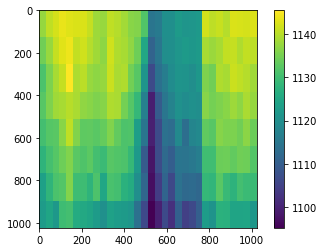

In [359]:
tab = Table.read('ecs_pha_fits/e50/i3_noTG.lloc', format='ascii', header_start=1)
plt.imshow(reg2im1024(tab, 'Ti').T)
plt.colorbar()

Im my plot, the (0,0) point is at the top left, but that's obviously just a choice for visualization. Since each area on the chip is 32 * 128 pixels large, I can make a more compressed version of the same data where I represent each region buy just one pixel (same data but the data for epoch 0 is already subtracted to present the dPHA value instead of the PHA):

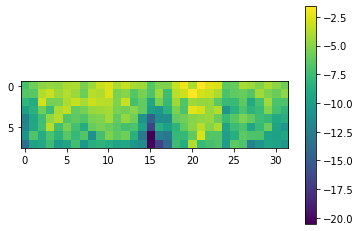

In [362]:
plt.imshow(dat['i3_noTG'][0][49, 0, :].reshape(32, 8).T)
plt.colorbar()

## PCA results per chip

In [233]:
def plot_explained_var_ratio(ax, arr):
    for sl, label in zip([0, 1, 2, slice(4)], ['Al', 'Ti', 'Mn', 'All']):
        pca = PCA()
        projected = np.ascontiguousarray(pca.fit_transform(arr[:, sl, :].reshape([-1, 256])))
        ax.plot(np.arange(pca.n_components_) + 1, # to make x axis start as 1
                np.cumsum(pca.explained_variance_ratio_), label=label)
    ax.set_xlabel('number of components')
    ax.set_ylabel('cumulative explained variance')
    ax.legend()
    ax.set_xlim(0, 30) 
    ax.set_ylim(None, 1)

In [296]:

elements = ['Al', 'Ti', 'Mn']
lineprops = {'Al': {'lw': 5, 'alpha': .5},
             'Mn': {'ls': ':'},
             'Ti': {}}
# set color cycle for absolute number
max_comp=8
compcolors = plt.cm.nipy_spectral(np.linspace(0, 1, max_comp))

In [248]:
def plot_overview(arr, err, proj):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

    plot_explained_var_ratio(axes[0, 0], arr)

    axes[1, 0].plot(epochs['date'].jyear, np.nanmean(err, axis=(1,2)))
    axes[1, 0].set_ylabel('Average error [channels]')
    # All PCA components
    for j in range(7, -1, -1):
        for i, elem in enumerate(['Al', 'Ti', 'Mn']):
            out = axes[0, 1].plot(epochs['date'].jyear, proj[:, i, j], **lineprops[elem], color=compcolors[j], 
                              label=elem if j==0 else '__no_legend__')
    axes[0, 1].legend()
    axes[0, 1].set_title('PCA components')
    axes[0, 1].set_ylabel('Scaling of component')
    
    # All PCA components except for the first
    for j in range(7, 0, -1):
        for i, elem in enumerate(['Al', 'Ti', 'Mn']):
            out = axes[1, 1].plot(epochs['date'].jyear, proj[:, i, j], **lineprops[elem], color=compcolors[j],
                         label=f'{j + 1}' if i == 0 else '__no_legend__')
    axes[1, 1].legend(title='PCA comp', ncol=2)
    axes[1, 1].set_title('PCA component 2-7')
    axes[1, 1].set_ylabel('Scaling of component')
    
    return fig, axes

In the following, I show a set of four plots for each chip. (BI chips are shown twice, with and without CTI.).

*top left:* Cumulative explained variance depending on the number of components used in the PCA. This is done four times: Once for Al, Ti, and Mn each (i.e. with 74 input epochs) and one using all the data for one chip at the same time. The more information is available, the better the PCA components will be and the dPHA maps for Al, Ti, and Mn are clearly similar, so it makes sense to try to describe them with the same spatial components. As an example, for the I0 chip, 95% of the variance in the Mn data can be explained with just one spatial component. The more componnents are used, the more of the variance will be explained. However, given that the input data contains noise, there is not need to aim to explain everything. Instead, we are looking for the most important components and will ignore the less important ones, that just fit the noise. In all chips, Al needs more components, but (not shown here directly) it's also the most noisy data.

*bottom left:* Average error in the dPHA maps over time. As the calibration source decays, the average error increases. That means that there will be more noise in the PCA decompositions of data taken more recently.

*right column:* Scaling factor for te PCA components over time. Different colors are for different compoments, different line styles for Al, Ti, and Mn. For example, the Ti image of a particular epoch is scaling of component 1 multiplied by the spatial component 1, plus the scaling of component 2 multiplied by compoennt 2 and so on (image of the compoments are shown in the next figure). 

*Top right:* Scaling of the first few PCA components. 
*Bottom right:* The first (the strongest) component is much more important than the next few, so this is the same plot without the first component.

noise at end, compoents that are only noise, correlation between elements

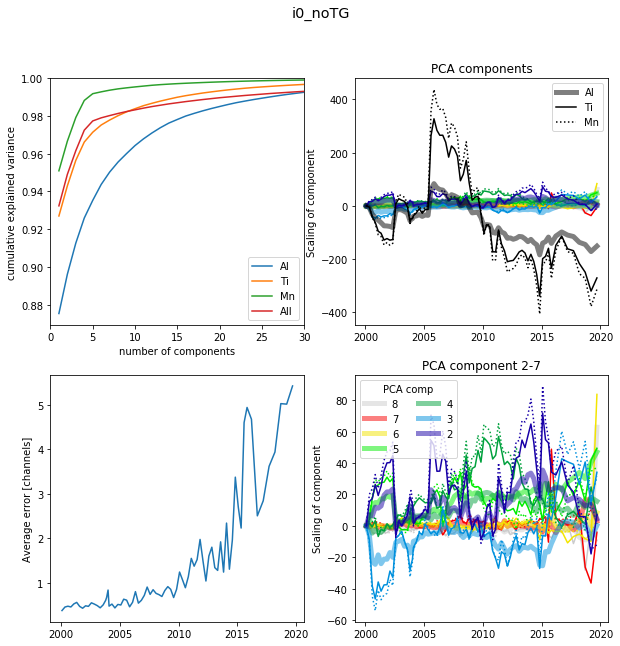

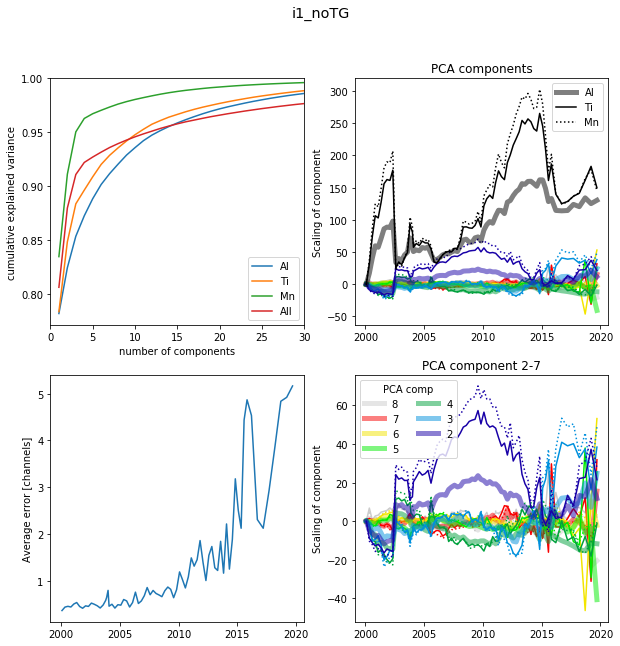

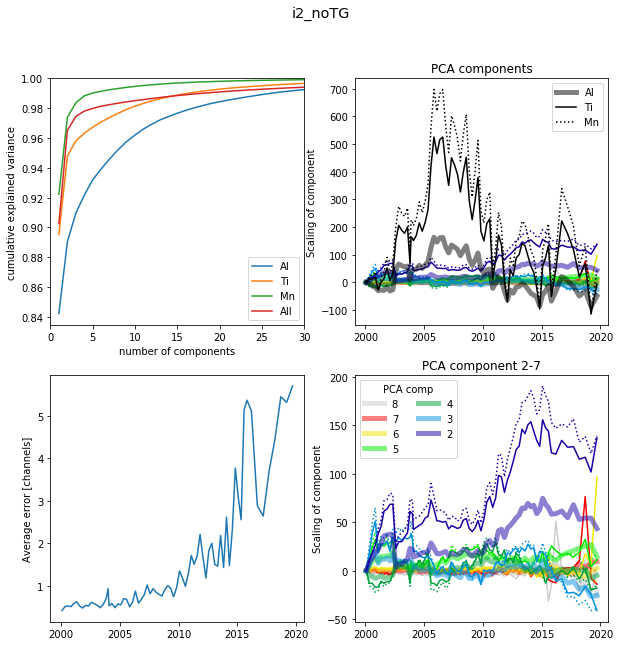

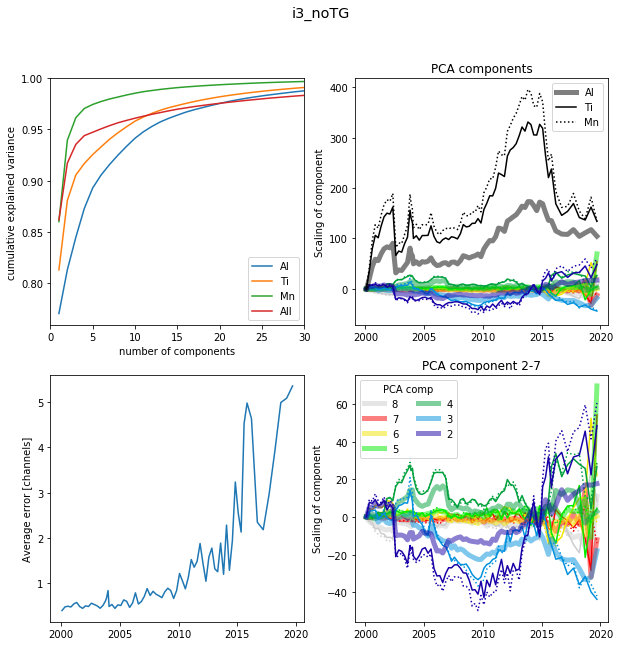

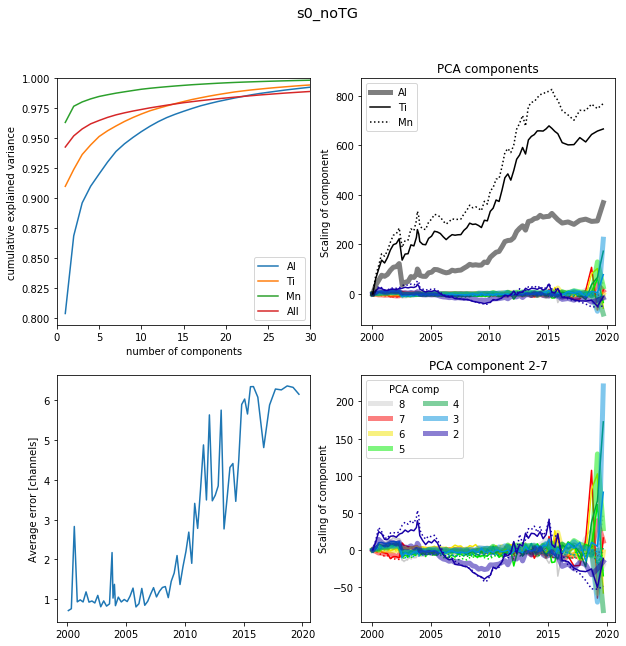

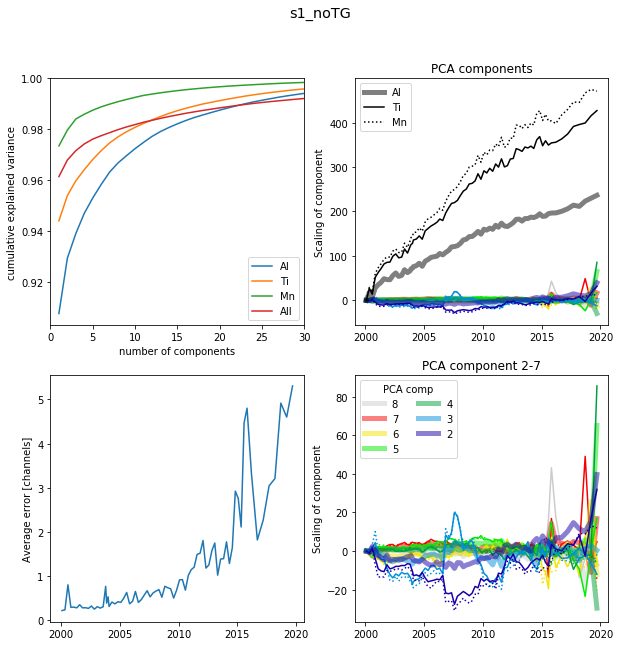

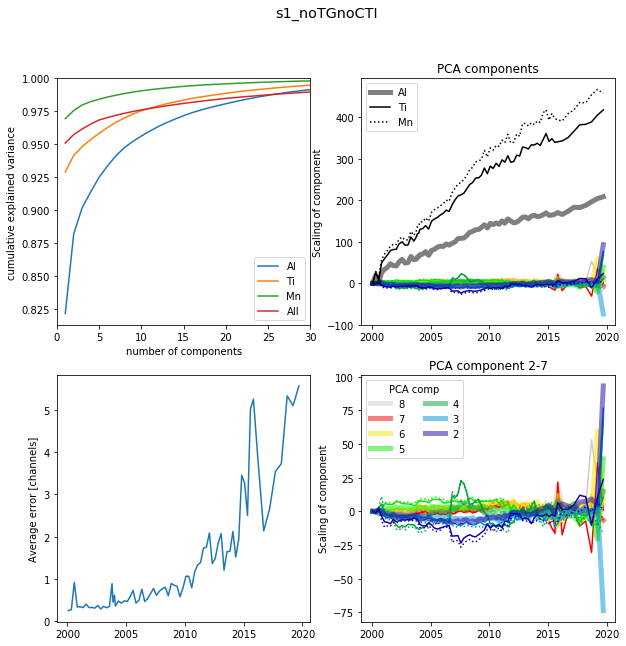

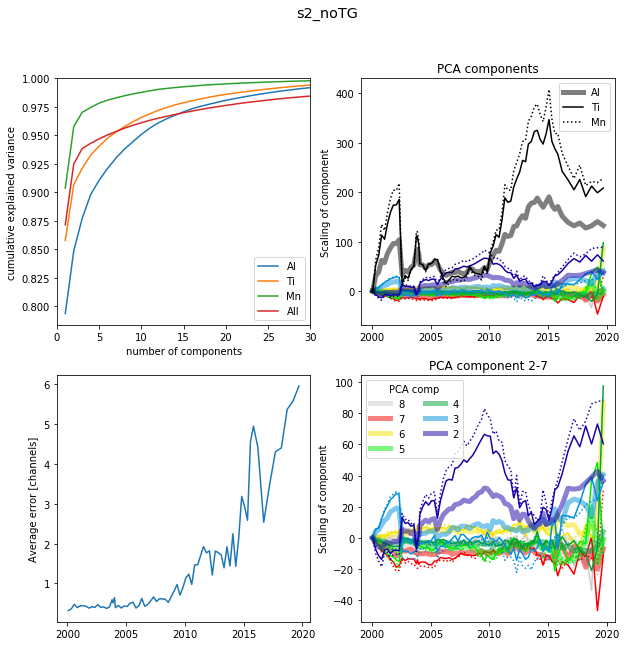

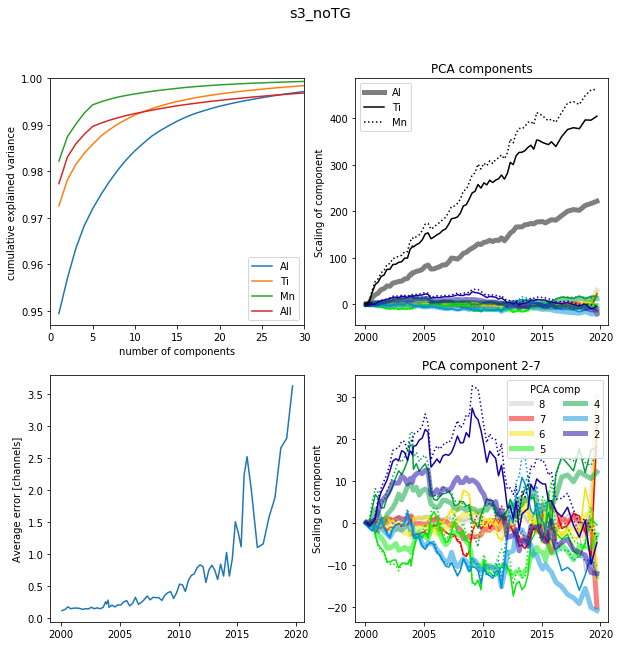

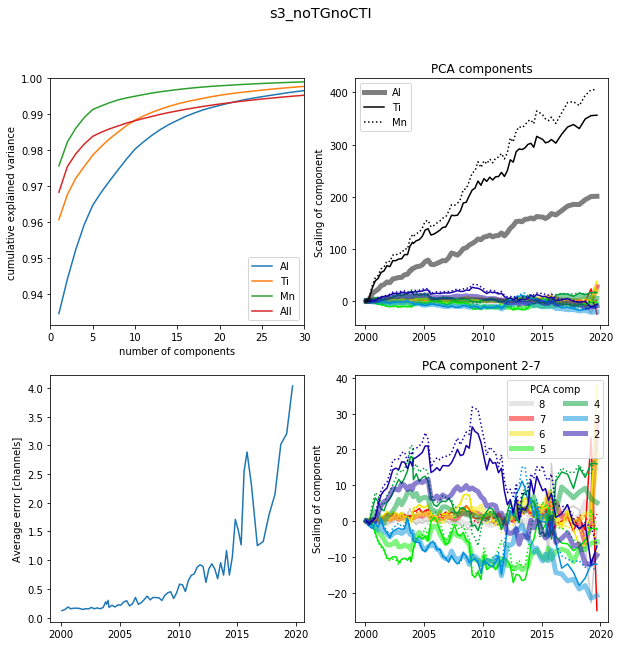

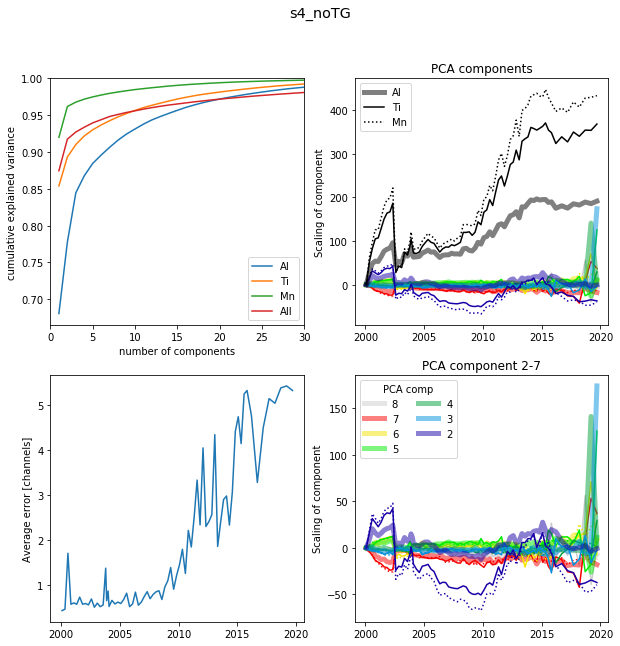

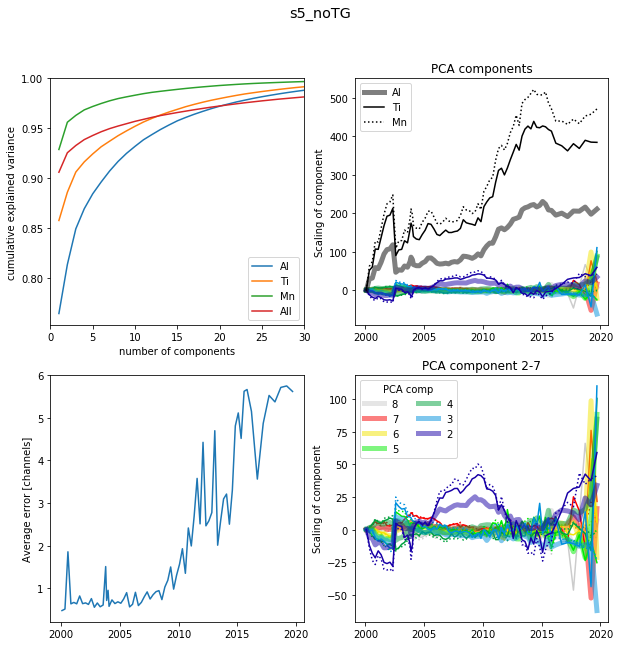

In [297]:
for k, v in dat.items():
    fig, axes = plot_overview(v[0], v[1], v[3])
    fig.suptitle(k, fontsize='x-large')

Let's compare chips a little more. To make everything fit on one plot, i'm going to show just the scaling of the strongest PCA component for all chips.

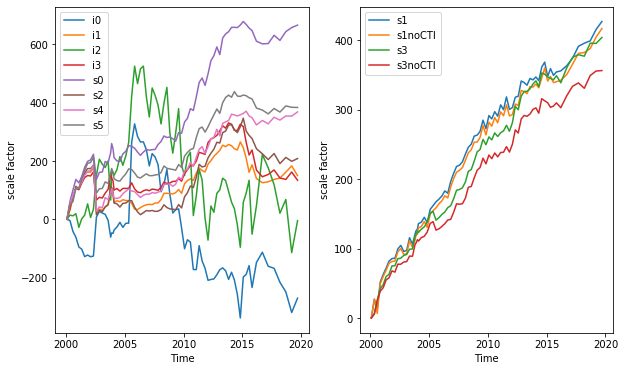

In [264]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 6))
for k in fi_chips:
    axes[0].plot(epochs['date'].jyear, dat[k][3][:, 1, 0], label=k.replace('_noTG', ''))
axes[0].legend()
    
for k in bi_chips:
    axes[1].plot(epochs['date'].jyear, dat[k][3][:, 1, 0], label=k.replace('_noTG', ''))
axes[1].legend()

for ax in axes:
    ax.set_xlabel('Time')
    ax.set_ylabel('scale factor')

Scale factor for the strongest component in the PCA. *left:* FI chips, *right:* BI chips.

This plots shows that chips fall into essentially three groups: For BI chips, the scale factor of the strongest component changes essentially linear with time (with a small offset in the first two years). The FI chips shows two different behaviours: While I2 developed an offset from I0 in the beginning, both chips have been developing in parallel since about 2003. The remaining chips (I1, I3, S0, S2, S4, S5), from another group with very similar time evolution. In all cases, the scale factor moves up quickly between 2000 and 2003, when a sudden jump down occurs that bring some of the chips back down to 0. (Is there a know reason, e.g. change in temperature of charge?) After that, this group develops largely in parallel, with the same offset. Only in recent year (after 2015 or so) do the scale factors diverge more.

If there is any use for it, it might be possible to find a prameterization of those three groups, i.e. we can fit a contanst to the BI chips (see below), treat I0 and I2 the same after 2003 (except for an offset), and describe the remaining chips as e.g. I1 + a low-order polynom. That way, we could predict the dPHA for all chips from measurements from just three observations.

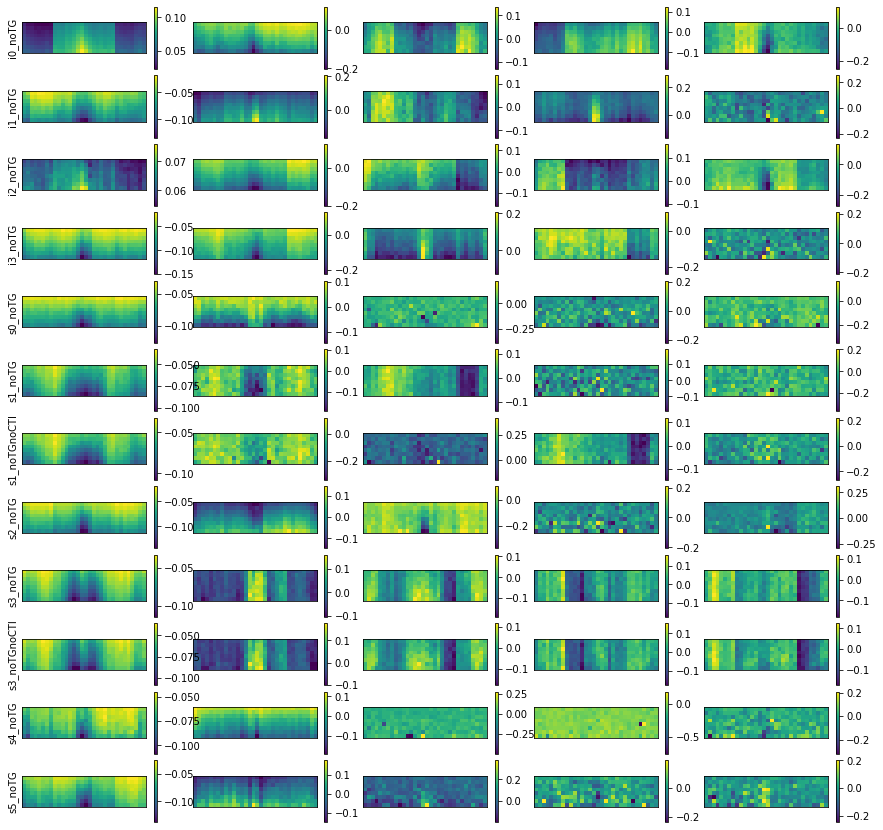

In [267]:
fig, axes = plt.subplots(ncols=5, nrows=len(chips), figsize=(15, 15),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
    
for i, k in enumerate(dat.keys()):
    pca = dat[k][2]
    for j in range(5):
        out = axes[i, j].imshow(pca.components_[j].reshape(32, 8).T)
        plt.colorbar(out, ax=axes[i, j])
    axes[i, 0].set_ylabel(k)

Top five most important PCA components (left to right) for different chips (rows). Some similarities are seen with the analysis of the scale factors presented above, e.g. I0 and I2 have similar spatial components. In most cases, spatial structure is clearly evident in these components, indication that they indeed have some physical relevance (Remember that the PCA by itself does not now anytihng about the 2D structure. Each "image" is siple a 1D vector of 256 numbers.)
For comparison, the plot below shows some components of lesser imporantance (example are components 5 to 9 for the I0 chip), which mostly look like noiss, sometimes with a single hot pixel. Here, compoenent 9 (rightmost plot) has some special structure again which is consistent with the 4 nodes on the chip, but the image is much noisier than the components shown in the previous plot.

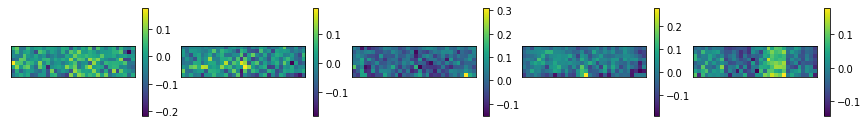

In [272]:
pca = dat['i0_noTG'][2]
fig, axes = plt.subplots(1, 5, figsize=(15, 2),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    out = ax.imshow(pca.components_[i + 5].reshape(32, 8).T)
    plt.colorbar(out, ax=ax)

### Energy dependence

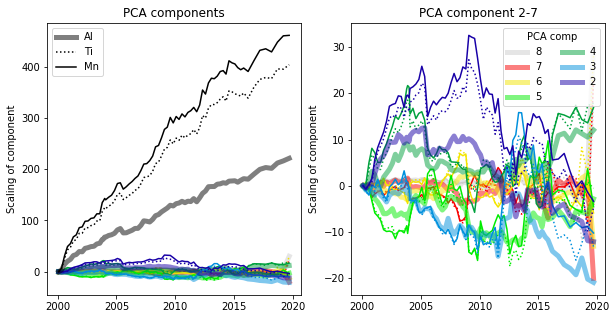

In [286]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

proj = dat['s3_noTG'][3]
# All PCA components
for j in range(7, -1, -1):
    for i, elem in enumerate(['Al', 'Ti', 'Mn']):
        out = axes[0].plot(epochs['date'].jyear, proj[:, i, j], **lineprops[elem], color=compcolors[j], 
                              label=elem if j==0 else '__no_legend__')
axes[0].legend()
axes[0].set_title('PCA components')
axes[0].set_ylabel('Scaling of component')
    
# All PCA components except for the first
for j in range(7, 0, -1):
    for i, elem in enumerate(['Al', 'Ti', 'Mn']):
        out = axes[1].plot(epochs['date'].jyear, proj[:, i, j], **lineprops[elem], color=compcolors[j],
                        label=f'{j + 1}' if i == 0 else '__no_legend__')
axes[1].legend(title='PCA comp', ncol=2)
axes[1].set_title('PCA component 2-7')
out = axes[1].set_ylabel('Scaling of component')

This figure repeats the plots from above that show the importance of different PSA components, here for the S2 chip as an example. *Left:* Components 1-7. *Right:* Same plot without component 1, so that the the lesser components can be seen better. It is obvious that the shape of the curves for each order is very similar for Al, Ti, and Mn, but with some scale facter in between. If this is true at least for the strong components where noise is not dominant, then we can fix this ratio in the in the future, and fit all three lines together, reducing the number of free components and thus we can make due with a lower observed signal.

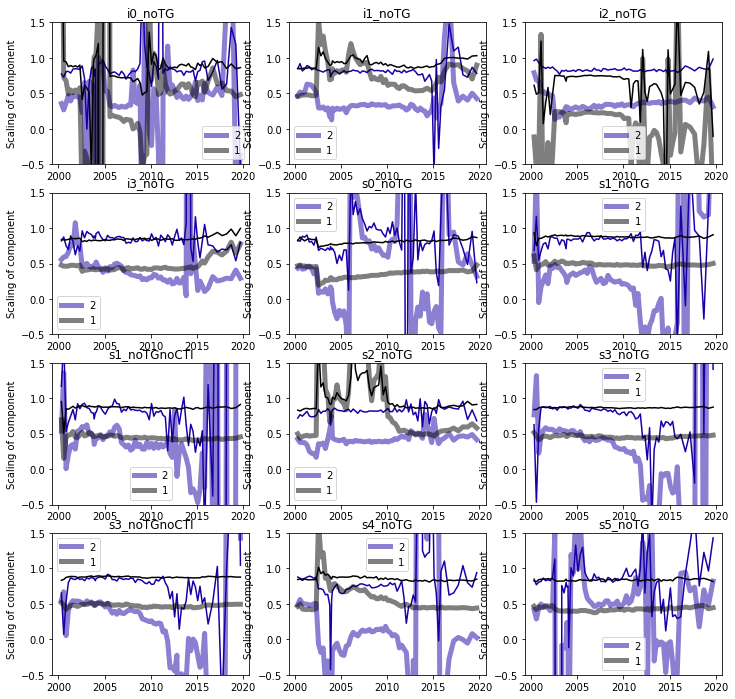

In [299]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

for ax, k in zip(axes.flatten(), dat.keys()):
    proj = dat[k][3]
    for j in range(1, -1, -1):
        for i, elem in enumerate(['Al', 'Ti']):
            with np.errstate(invalid='ignore', divide='ignore'):
                out = ax.plot(epochs['date'].jyear, proj[:, i, j] / proj[:, 2 , j], 
                              **lineprops[elem], color=compcolors[j], 
                              label=str(j + 1) if i==0 else '__no_legend__')
    ax.legend()
    ax.set_title(k)
    ax.set_ylabel('Scaling of component')
    ax.set_ylim([-.5, 1.5])


This plot shows the ratio of the PCA component scalings for Al/Mn (thick lines) and Ti/Mn (solid, thin lines) for all chips. In many cases, especially for the strongest component (1), the Ti/Mn ratio is constant of time with a value of 0.8 and Al/Mn is constant with a value of 0.5. However, that dependence is far from universal, and even for chips that are "well behaved" most of the time there can be periods where the fits deviate dramatically from that ratio (e.g. 2003 to 2010 for S2). Thus, unless a physical cause for this behaviour is identified, the ratios are not stable enough to be used for predictions.

## Do we need calibrations for BI chips ever again?

As shown above, the first component of the PCA already describes most of the variability. For BI chips in Ti and Mn (Al has more noise so more variablity is expected from just that), this component alone already describes 98 % of the variablity of the observed dPHA values. Also, the scale factor of this component is very linear after about 2001 for the BI chips, so it is worthwhile to see how we would do if we had stopped calibration **3 years ago** and instead just apply the linear trend with data measured up to 2017.0 and predict how the dPHA would look now.

In the next figure, we repeat analysis from above. First, we run PCA and then fit a linear slope to the growths of the first component, **but we only use data up to 2017.0**. The different line styles distinguish Al, Ti, and Mn and above.

In [221]:
ind = epochs['date'].jyear < 2017
pca, proj = do_pca(s3)
pca_2017, proj_2017 = do_pca(s3[ind, :, :])

coeff = np.polynomial.polynomial.polyfit(epochs['date'].jyear, proj[:, :, 0], deg=1)
coeff_2017 = np.polynomial.polynomial.polyfit(epochs['date'].jyear[ind], proj_2017[:, :, 0], deg=1)

In [222]:
default_color = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_linear_fits(proj, coeff, coeff_2017):
    for i, e in enumerate(elements):
        plt.plot(epochs['date'].jyear, proj[:, i, 0], color=default_color[0], **lineprops[e],
                label='observed' if i == 2 else '__no_legend__')
        # Of course, it's easy to write out a polynomial of degree 1.
        # I'm using np.polynomial.Polynomial here to save me some typing
        # if we ever go to higher degrees.
        plt.plot(epochs['date'].jyear, 
                 np.polynomial.Polynomial(coeff_2017[:, i])(epochs['date'].jyear), 
                 color=default_color[1], **lineprops[e],
                 label='fit to 2017.0' if i == 2 else '__no_legend__')
        plt.plot(epochs['date'].jyear, 
                 np.polynomial.Polynomial(coeff[:, i])(epochs['date'].jyear),
                 color=default_color[2], **lineprops[e],
                 label='fit today' if i == 2 else '__no_legend__')
    plt.legend()
    plt.xlabel('year')
    plt.ylabel('coeff')

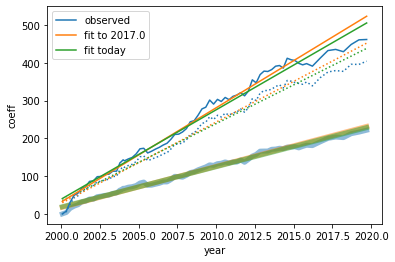

In [223]:
plot_linear_fits(proj, coeff, coeff_2017)

In [211]:
def plot_predict_one_comp(arr, err, pca, coeff, i):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,5))
    obs = arr[-1, i, :].reshape(32, 8).T
    predicted = (coeff[0, i] + coeff[1, i] * epochs['date'].jyear[-1]) * pca.components_[0].reshape(32, 8).T
    err = err[-1, i, :].reshape(32, 8).T
    
    vmin = min(obs.min(), predicted.min())
    vmax = max(obs.max(), predicted.max())

    im = axes[0, 0].imshow(obs, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=axes[0, 0])
    axes[0, 0].set_title('Observed')
    im = axes[1, 0].imshow(err, vmin=0)
    plt.colorbar(im, ax=axes[1, 0])
    axes[1, 0].set_title('Obs. uncertainty')

    im = axes[0, 1].imshow(predicted, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=axes[0, 1])
    axes[0, 1].set_title('Predicted with just one component')
    im = axes[1, 1].imshow(obs - predicted)
    plt.colorbar(im, ax=axes[1, 1])
    axes[1, 1].set_title('obs-predicted')
    redchi2 = np.sum((obs - predicted)**2 / err**2) / err.size
    return fig, axes, redchi2

chi^2=1.08


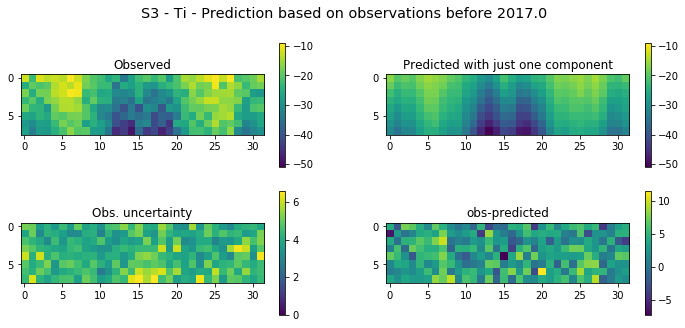

In [214]:
i = 1
fig, axes, chi2 = plot_predict_one_comp(s3, s3err, pca_2017, coeff_2017, i)
out = fig.suptitle('S3 - {} - Prediction based on observations before 2017.0'.format(elements[i]),
                   fontsize='x-large')
print(f'red chi^2={chi2:4.2f}')

*top left:* Most recent observed pPHA map,
*top right:* Predicted map using just the strongest component of the PCA, where the PCA is done on observations up to 2017.0.
*bottom left:* Estimate of the noise in the observed data.
*bottom right:* Difference between observed and predicted data.

Here, the observed data shows smaller values of the dPHA then the prediced one. That can be expected from the fit above, which already shows that the (almost) linear dependence as flattened a little on recent years and thus the dPHA using earlier data only will be oberpredicted by a little. Thus, the difference between observations and prediction is slightly skewed toward positive numbers. There is also a hint of a systematic pattern with most positive numbers in the bottom right plot concentrated between x values of 5-10. Yet, the $\chi^2$ of this simple model is already 1.08. 

## How many spatial components are necessary to obtain a satisfactory fit?

In [341]:
def plot_chi2(elem):
    fig, axes = plt.subplots(4, 3, figsize=(12, 12))
    axes = axes.flatten()

    for ax, k in zip(axes.flatten(), dat.keys()):
        arr, err, pca, proj = dat[k]
        for n in [1, 3, 5, 10, 50]:
            predict_n = proj[:, :, :n] @ pca.components_[:n, :]
            redchi2 = np.nansum((arr - predict_n)**2 / err**2, axis=2) / err.shape[-1]
            ax.semilogy(epochs['date'].jyear, redchi2[:, elements.index(elem)], label=str(n))
        ax.set_title(k)
        ax.set_ylim(.1, 20)
        ax.set_ylabel('red. $\chi^2$')
    axes[4].legend(ncol=3)
    fig.subplots_adjust(hspace=.3, wspace=.3, top=.93)
    fig.suptitle(f'$\chi^2$ over time for fits to {elem} line with n spatial components', fontsize='x-large')
    return fig, axes

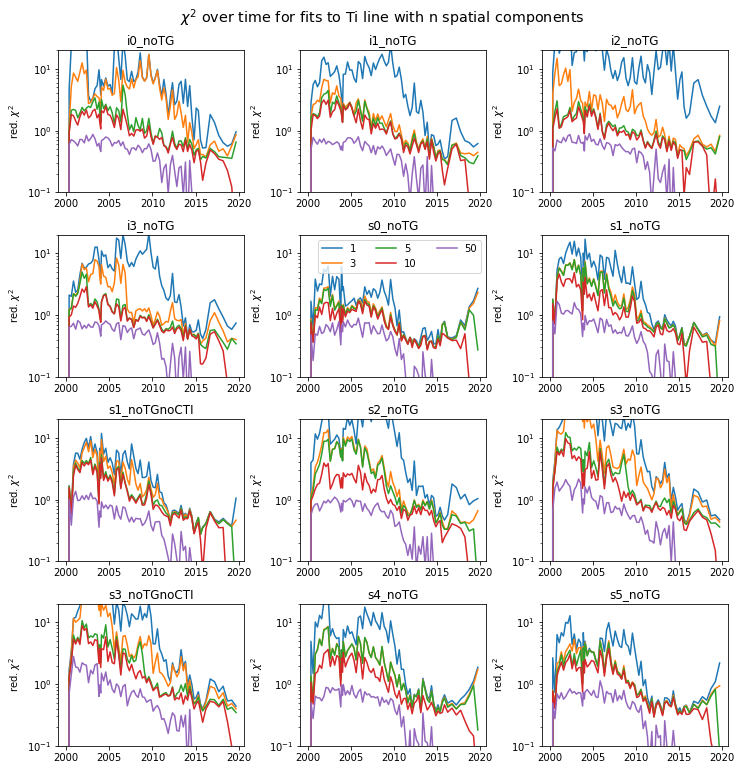

In [343]:
fig, axes = plot_chi2('Ti')

This plot shows the reduced $\chi^2$ that a desrciption with the first $n$ components of the PCA can give for each chip (here for the Ti line). In general, the $\chi^2$ drops with time for any chosen $n$. We already showed above that the measurement uncertainty increases with time, as the intensity ofthe calibration source decreases. In itself, that is not surprising. While the shapes of the curves are similar, the scale differs. For most cases,several dozen components are necessary to reach  $\chi^2$ around one for earliy times, in other words, each region on the detector actually evolves different. However, with decreasing signal, less and less of that can the measured reliably, and at later times, after 2015 or so, good fits can often be obtained with just one or two spatial components. In several chips, there is a noticable uptick in $\chi^2$ in 2019. I suspect that this is dues to new systematics becoming important that are not treated properly in this analysis, namely the count number becomes so low that for some regions a Gaussian error appoximation is not appropriate any longer. For completeness, equivalent plots for Al and Mn are shown below.

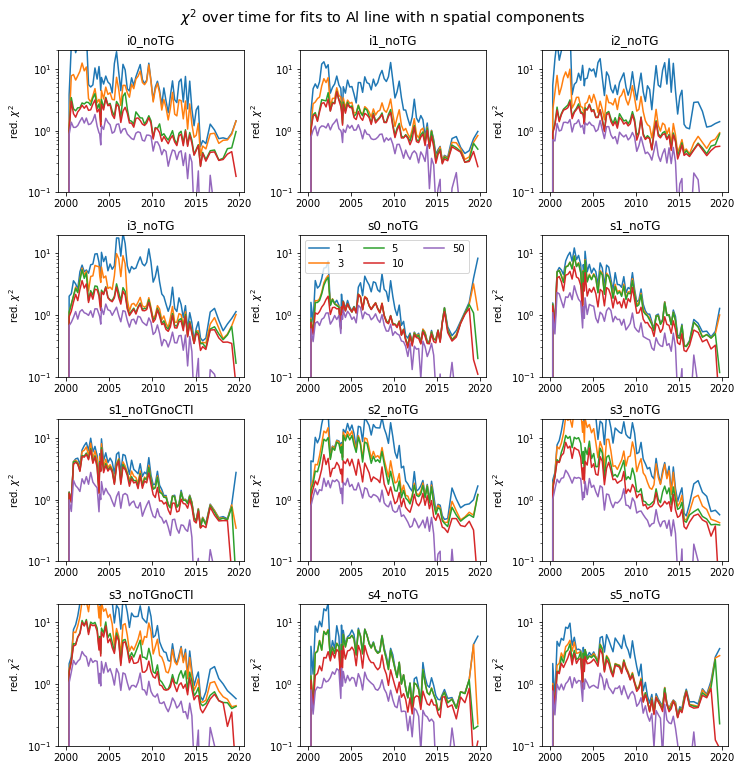

In [344]:
fig, axes = plot_chi2('Al')

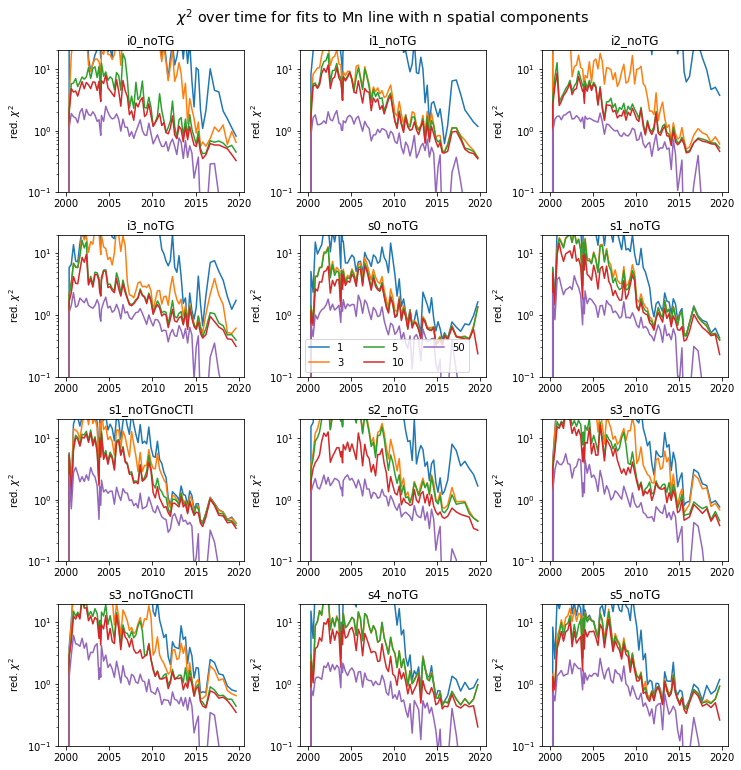

In [345]:
fig, axes = plot_chi2('Mn')

## Conclusions

While the dPHA images in the beginning of the mission contain a lot of information about small scale changes, in the last few years, the noise has grown to the point where a satisfactory $\chi^2$ can be obtained by describing the dPHA maps with just one (or a few) components. That means that the dPHA the we produce from fitting the observations in each region independently carry more noise than justified. Instead, **we should fit the dPHA maps from about 2015 on as  a linear combination of just one or a few components**. That way, we have only 1 (or a few) free parameters, which can be determined much better than 256 independent regions. 

**For future calibrations, we can just fit one (or a few) parameters and construct the dPHA as a linear combination of the known most important (or the few most important) spatial components.** Consequently, the is no need ot illuminate the entire detector. Instead, we can place an astrophysical calibration source such as Cas A so that it illuminates only a few regions. If we use only one spatial component, any region on the detector will do. If we decided to use three or four spatial components, the source should be placed such that that fit as a "good handle" on the parameters, i.e. area where te spatial shape of the top few components is very similar shoudl be avoided and area where the chosen components have large, and most importantly, different spatial gradients are ideal.

In particular the BI chips are very well described with just one spatial component, which moreover is scaled almost linearly with time.

## Notes
Some notes for me or anyone else who might pick up this analysis later again:

- I tried other spatical decompositions, such as ICA (Independent Component Analysis) and NMF (Non-Negative Matrix Factorization), but results look more noisy and are not as easy to interpert and use. Thus, I refrain from repeating all plots for different schemes.